# Visual Odometry for Localization in Autonomous Driving

## Importing All Packages 

In [1]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


## Loading and Visualizing the Data

In [2]:
# Number of Frames
num_frames = 20

data_images = []
data_images_rgb = []
data_depth_maps = []

k = np.array([[640, 0, 640],
              [0, 480, 480],
              [0,   0,   1]], 
            dtype=np.float32)

i = 10


In [3]:
# Load Images
def loadImages(num_frames):
        images = []
        images_rgb = []
    
        for i in range(1, num_frames + 1):
            zeroes = "0" * (5 - len(str(i)))
            image_name = "{0}/frame_{1}{2}.png".format('image', zeroes, str(i))
            images.append(cv2.imread(image_name, flags=0))
            images_rgb.append(cv2.imread(image_name)[:, :, ::-1])
        
        return images, images_rgb

In [4]:
# Load Depth Maps
def loadDepthMaps(num_frames):
    
    depth_maps = []
    
    for i in range(1, num_frames + 1):
            zeroes = "0" * (5 - len(str(i)))
            depth_name = "{0}/frame_{1}{2}.dat".format('depth', zeroes, str(i))
            depth = np.loadtxt(
                depth_name,
                delimiter=',',
                dtype=np.float64) * 1000.0
            depth_maps.append(depth)
    
    return depth_maps

### Loading Data

In [5]:
data_images, data_images_rgb = loadImages(num_frames);
data_depth_maps = loadDepthMaps(num_frames);

### Visualizing Data

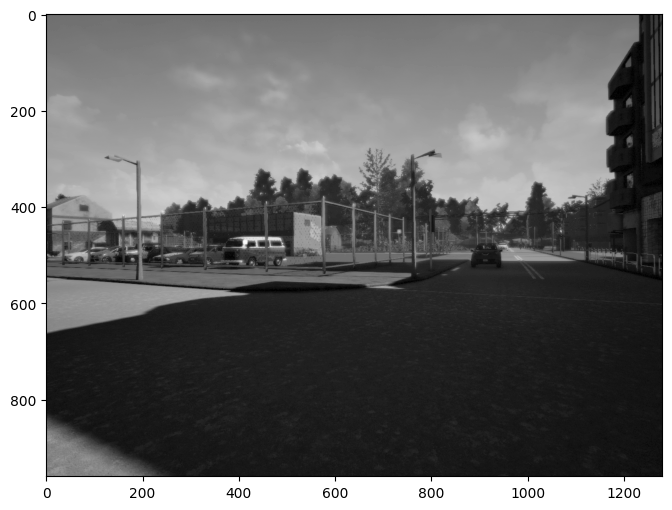

In [6]:
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(data_images[i], cmap='gray')

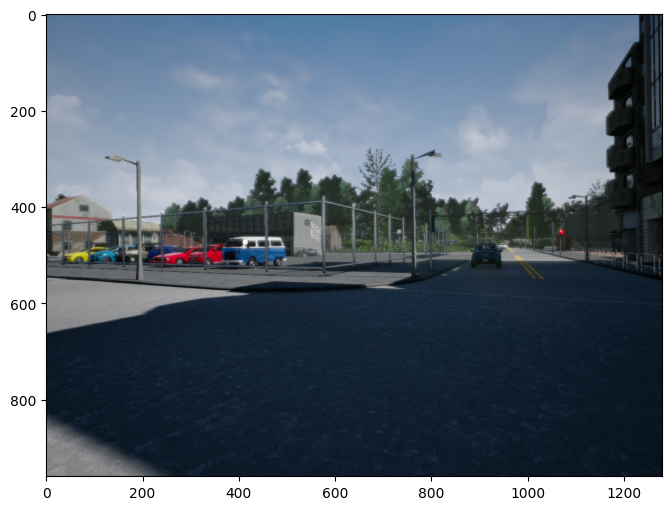

In [7]:
image_rgb = data_images_rgb[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)

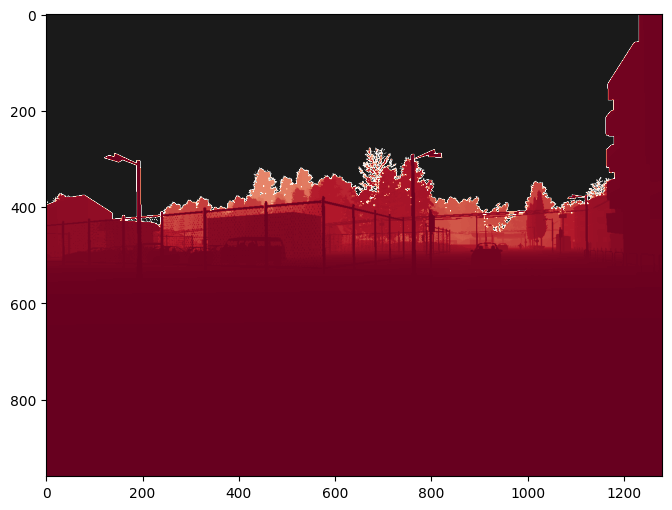

In [8]:
 
depth = data_depth_maps[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='RdGy')

## Feature Extraction

In [9]:
def getFeatures(image): 
    keypoints, descriptor = cv2.SIFT_create(10000).detectAndCompute(image, None)
    return keypoints, descriptor

In [10]:
def showFeatures(image, keypoints):
    display = cv2.drawKeypoints(image, keypoints, None)
    plt.figure(figsize=(8, 6), dpi=200)
    plt.imshow(display)

### 3.1 - Extracting Features From Single Frame

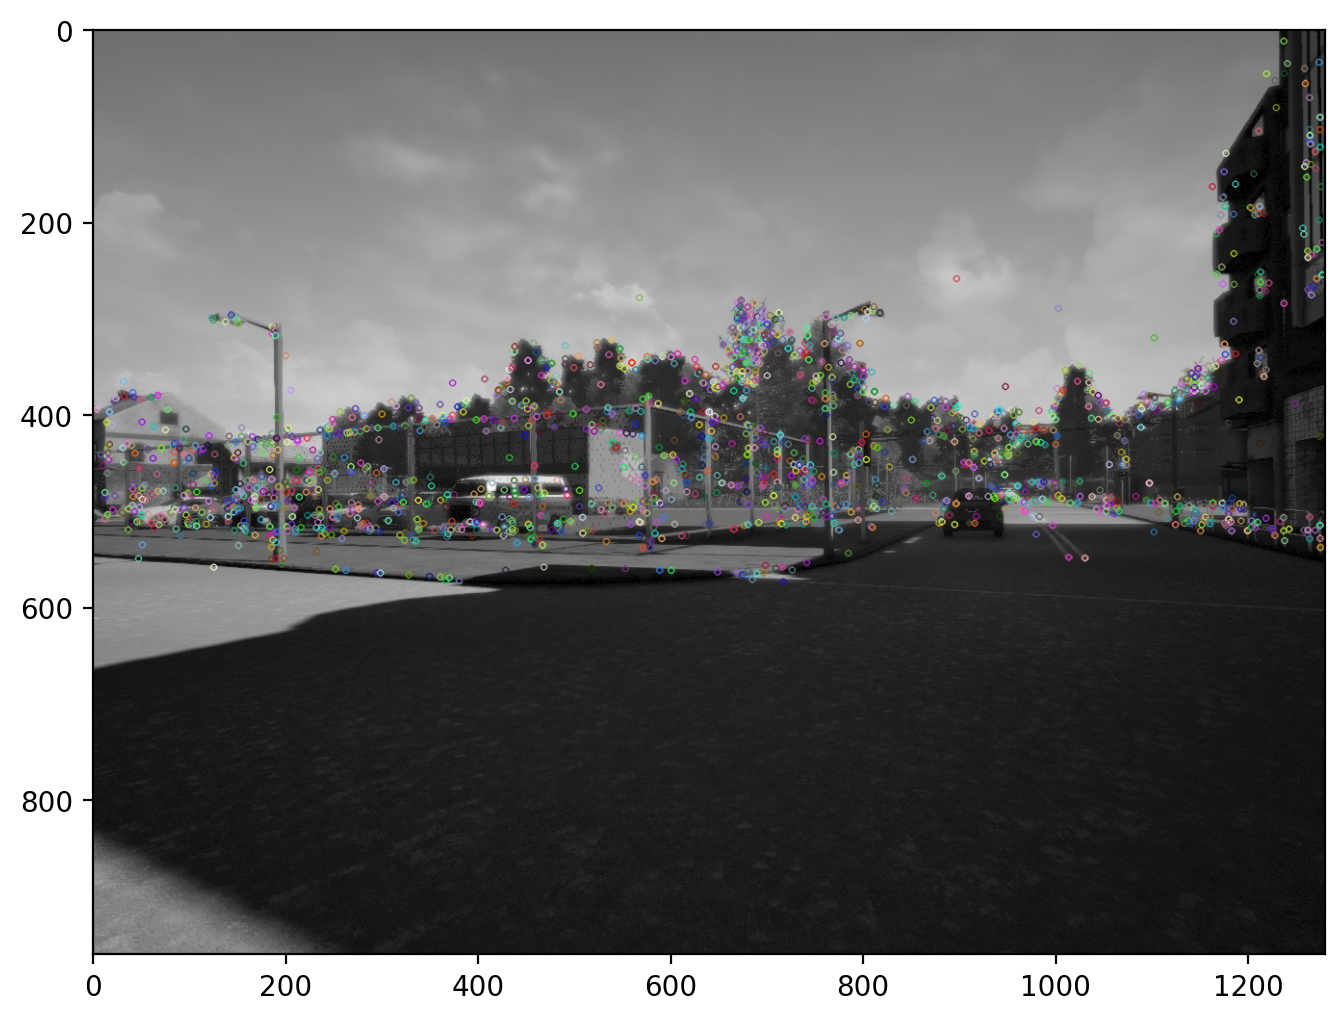

In [11]:

image = data_images[i]
keypoints, descriptor = getFeatures(image)
showFeatures(image, keypoints)

### Extracting Features From All Frames

In [12]:
def getFeatures_dataset(images, getFeatures_function):
    keypoints_list = []
    descriptor_list = []
    
    for img in images:
        keypoints, descriptor = getFeatures(img)
        keypoints_list.append(keypoints)
        descriptor_list.append(descriptor)
    
    return keypoints_list, descriptor_list

In [13]:

keypoints_list, descriptor_list = getFeatures_dataset(data_images, getFeatures)
 
print("Features detected in: ")
for i in range(20):
    print("- Frame {0}: {1}".format(i, len(keypoints_list[i])))

Features detected in: 
- Frame 0: 1508
- Frame 1: 1528
- Frame 2: 1580
- Frame 3: 1584
- Frame 4: 1632
- Frame 5: 1691
- Frame 6: 1721
- Frame 7: 1743
- Frame 8: 1767
- Frame 9: 1795
- Frame 10: 1875
- Frame 11: 1869
- Frame 12: 1853
- Frame 13: 1913
- Frame 14: 1997
- Frame 15: 1903
- Frame 16: 2042
- Frame 17: 2026
- Frame 18: 2014
- Frame 19: 2006


## Feature Matching

### Matching Features from a Pair of Subsequent Frames:

In [14]:
def matchFeatures(descriptor1, descriptor2):

    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
   
    # match and sort in the order of their distance.
    match = sorted(bf.match(descriptor1,descriptor2), key = lambda x:x.distance)
    return match

In [15]:
 i=10

match = matchFeatures(descriptor_list[i], descriptor_list[i+1])
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))

Number of features matched in frames 10 and 11: 905


### Matching Features in Each Subsequent Image Pair in the Dataset

In [16]:
def matchFeaturesList(descriptor_list, matchFeatures):

    matches = []

    for i in range(len(descriptor_list)-1):
        descriptor1 = descriptor_list[i]
        descriptor2 = descriptor_list[i+1]
        match = matchFeatures(descriptor1, descriptor2)
        matches.append(match)
    
    return matches

In [17]:
matches = matchFeaturesList(descriptor_list, matchFeatures)

 
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 10 and 11: 905


## Trajectory Estimation

### Estimating Camera Motion between a Pair of Images

In [18]:
def estimateCameraMotion(match, keypoints1, keypoints2, k):

    rmat = np.eye(3) # Rotation Matrix
    tvec = np.zeros((3, 1)) # Translation Vector
    image1_points = []
    image2_points = []
    
    for m in match:
        
        train_idx = m.trainIdx
        query_idx = m.queryIdx
        
        x1, y1 = keypoints1[query_idx].pt
        image1_points.append([x1, y1])

        x2, y2 = keypoints2[train_idx].pt
        image2_points.append([x2, y2])

    E, mask = cv2.findEssentialMat(np.array(image1_points), np.array(image2_points), k)
    
    retval, rmat, tvec, mask = cv2.recoverPose(E, np.array(image1_points), np.array(image2_points), k)

    return rmat, tvec, image1_points, image2_points

In [19]:
 

rmat, tvec, image1_points, image2_points = estimateCameraMotion(matches[i], keypoints_list[i], keypoints_list[i+1], k)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

Estimated rotation:
 [[ 9.99978520e-01  2.22770404e-03  6.16415927e-03]
 [-2.23022548e-03  9.99997432e-01  4.02204654e-04]
 [-6.16324745e-03 -4.15943480e-04  9.99980921e-01]]
Estimated translation:
 [[ 0.14609447]
 [-0.00596631]
 [-0.98925265]]


### Estimating Camera Trajectory

In [20]:
def estimateCameraTrajectory(estimateCameraMotion, matches, keypoints_list, k):
    trajectory = [np.array([0, 0, 0])]
    
    R = np.diag([1,1,1])
    T = np.zeros([3, 1])
    RT = np.hstack([R, T])
    RT = np.vstack([RT, np.zeros([1, 4])])
    RT[-1, -1] = 1
    
    for i in range(len(matches)):     
        match = matches[i]
        keypoints1 = keypoints_list[i]
        keypoints2 = keypoints_list[i+1]
        
        rmat, tvec, image1_points, image2_points = estimateCameraMotion(match, keypoints1, keypoints2, k)
        rt_mtx = np.hstack([rmat, tvec])
        rt_mtx = np.vstack([rt_mtx, np.zeros([1, 4])])
        rt_mtx[-1, -1] = 1
        
        rt_mtx_inv = np.linalg.inv(rt_mtx)
        
        RT = np.dot(RT, rt_mtx_inv)
        new_trajectory = RT[:3, 3]
        trajectory.append(new_trajectory)
    
    trajectory = np.array(trajectory).T
    
    return trajectory

In [21]:

trajectory = estimateCameraTrajectory(estimateCameraMotion, matches, keypoints_list, k)

 
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))
print("Length of trajectory: {0}".format(trajectory.shape[1]))

Camera location in point 10 is: 
 [[-0.42754971]
 [ 0.2271883 ]
 [ 9.9592972 ]]

Length of trajectory: 20


## Results

In [22]:
print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

Trajectory X:
 [[ 0.         -0.01007798 -0.05046067  0.00318821 -0.06858193 -0.11906057
  -0.15637846 -0.27352196 -0.2620968  -0.4520309  -0.42754971 -0.63149785
  -0.78771238 -0.99086361 -1.28302679 -1.66831387 -1.97824836 -2.41373655
  -2.72283756 -3.03114332]]
Trajectory Y:
 [[ 0.         -0.00374047  0.030393    0.07352822  0.08859884  0.03258431
   0.10419501  0.11703914  0.14043908  0.16459772  0.2271883   0.24300048
   0.20182233  0.12799584  0.12325534  0.16879835  0.23217342  0.24011516
   0.27317994  0.26461702]]
Trajectory Z:
 [[ 0.          0.99994222  1.99854331  2.99617108  3.99347841  4.9906315
   5.98736581  6.98039775  7.98005864  8.96155821  9.9592972  10.93815119
  11.9250156  12.9013758  13.85773253 14.77940477 15.72804812 16.62820753
  17.57866178 18.52991056]]
